Problem Definition
A bike‐rental dataset covering October 1 to December 22, 2023 (with rentals missing from October 31 to November 23) was analyzed to understand how weather, time of day, day of week, and holidays affect demand.

Findings

Weather Effects
- Temperature shows the strongest positive correlation with rental counts up to about 80 °F.
- Humidity correlates negatively—higher humidity leads to fewer rentals.
- Wind speed also has a mild negative impact on rentals.

Hourly Patterns
- Rentals are lowest around 5 AM.
- A modest morning peak occurs around 7 AM, then dips midday.
- The evening commute peak is at 5 PM, followed by a steady decline overnight.

Weekly Trends
- Demand declines Monday through Wednesday (with Wednesday lowest).
- From Thursday onward demand rises, peaking on Saturday.
-Holidays did not produce a marked deviation from typical patterns.

User Behavior Insight
- The timing and shape of peaks suggest many users ride for commuting, favoring bikes on the way home when temperatures are more comfortable and hands are free.

Conclusion
The analysis reveals clear temporal and weather‐related patterns in bike rentals. Temperature, humidity, and wind meaningfully influence demand, while weekday and hourly cycles highlight commuter behavior. Armed with these insights, the company can optimize inventory placement, schedule maintenance during low‐demand periods, and tailor promotions or pricing to peak windows. Further study—such as deeper investigation into humidity’s nonlinear effects—could refine these strategies even more.

In [1]:
# General data prep
#%pip install seaborn
# panda package import
import pandas            as pd  # data science package
import matplotlib.pyplot as plt # data visualisation package
import seaborn           as sns # data visualisation enhancement package


# storing the path to the dataset
file = "../data/bikes_data.xlsx"

# convert Holiday and functioningDay to category 
data_types = {"Holiday": "category", 
              "FunctioningDay": "category"}

# reading the file into Python through pandas 
bikes = pd.read_excel(io         = file,
                      sheet_name = 'data',
                      header     = 0,
                      dtype      = data_types,
                      usecols    = range(1, 13) ) #leaving out ID which I don't use


# print first 10 rows as a preview
bikes.head(n = 10)


,DateHour,Temperature(F),Humidity(%),Wind speed (mph),Visibility(miles),DewPointTemperature(F),Rainfall(in),Snowfall(in),SolarRadiation(MJ/m2),Holiday,FunctioningDay,RENTALS
0,2023-10-01 00:59:56.395,65,52,2.9,1.3,48.7,0.0,0.0,0.00,No,Yes,655
1,2023-10-01 02:59:56.385,63,52,3.4,2.0,46.6,0.0,0.0,0.00,No,Yes,274
2,2023-10-01 04:59:56.375,60,54,2.9,2.1,45.9,0.0,0.0,0.00,No,Yes,271
3,2023-10-01 05:59:56.370,63,55,2.7,2.3,46.0,0.0,0.0,0.00,No,Yes,658
4,2023-10-01 06:59:56.365,62,55,3.1,2.3,45.9,0.0,0.0,0.07,No,Yes,1556
5,2023-10-01 10:59:56.345,72,40,4.5,2.1,48.6,0.0,0.0,2.73,No,Yes,1022
6,2023-10-01 11:59:56.340,74,40,2.9,2.3,50.0,0.0,0.0,2.64,No,Yes,1252
7,2023-10-01 14:59:56.325,79,40,4.3,3.6,52.3,0.0,0.0,1.48,No,Yes,1234
8,2023-10-01 15:59:56.320,74,44,3.1,3.6,54.1,0.0,0.0,0.99,No,Yes,1588
9,2023-10-01 16:59:56.315,74,44,2.7,7.1,54.0,0.0,0.0,0.82,No,Yes,2193


In [2]:
# Data quality analysis, standardization and cleanup


# Convert categorical columns to numeric codes so I can work with them later
bikes['Holiday'] = bikes['Holiday'].cat.codes
bikes['FunctioningDay'] = bikes['FunctioningDay'].cat.codes


# check the data types
bikes.info(verbose = True)

missing_data = bikes.isnull().sum()
missing_data_percentage = (missing_data / len(bikes)) * 100

# Round the percentage of missing data to 0 decimal places
missing_data_percentage = missing_data_percentage.round(0)

print(f"\nPercentage of missing data per column:\n{missing_data_percentage}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateHour                1096 non-null   datetime64[ns]
 1   Temperature(F)          1096 non-null   int64         
 2   Humidity(%)             1096 non-null   int64         
 3   Wind speed (mph)        1096 non-null   float64       
 4   Visibility(miles)       1050 non-null   float64       
 5   DewPointTemperature(F)  1057 non-null   float64       
 6   Rainfall(in)            1096 non-null   float64       
 7   Snowfall(in)            1096 non-null   float64       
 8   SolarRadiation(MJ/m2)   1047 non-null   float64       
 9   Holiday                 1096 non-null   int8          
 10  FunctioningDay          1096 non-null   int8          
 11  RENTALS                 1096 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(3), int8

Data used for the analysis and conclusion has a good quality. Visibility, DewPointTemperature and SolarRadiation columns had 4% of missing data which were not significant so the analysis has been done on all rows. 

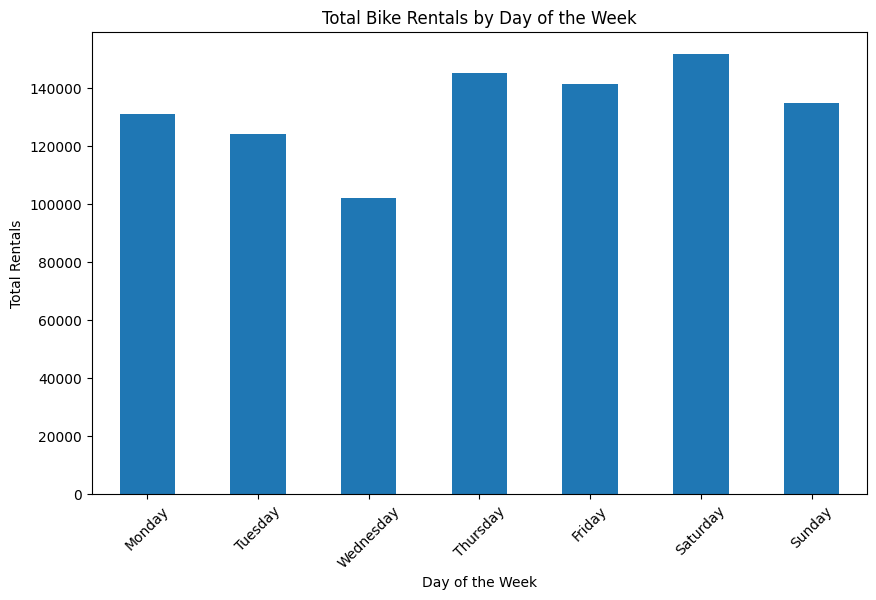

In [3]:
# Analysis on days in a week rental

# Extract the day of the week from 'DateHour'
bikes['DayOfWeek'] = bikes['DateHour'].dt.dayofweek

# Group by 'DayOfWeek' and sum the rentals
rentals_by_day = bikes.groupby('DayOfWeek')['RENTALS'].sum()

# Map the day of the week from numbers to names
days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
rentals_by_day.index = rentals_by_day.index.map(days_of_week)

# Plot the bar chart
plt.figure(figsize = (10, 6))
rentals_by_day.plot(kind = 'bar')
plt.title('Total Bike Rentals by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Rentals')
plt.xticks(rotation = 45)

# Calculate the average rentals
average_rentals = rentals_by_day.mean()

plt.show()

Visual inspection helps us to understand that the Wednesday is the day where we rented the lowest number of bikes while Saturday has the highest number of rentals

Room for improvement: Anova test to confirm/reject the hypothesis there is no significant diference in number of rentals in weekdays and weekends or T test if we want to compare  the two groups of weekend vs weekdays

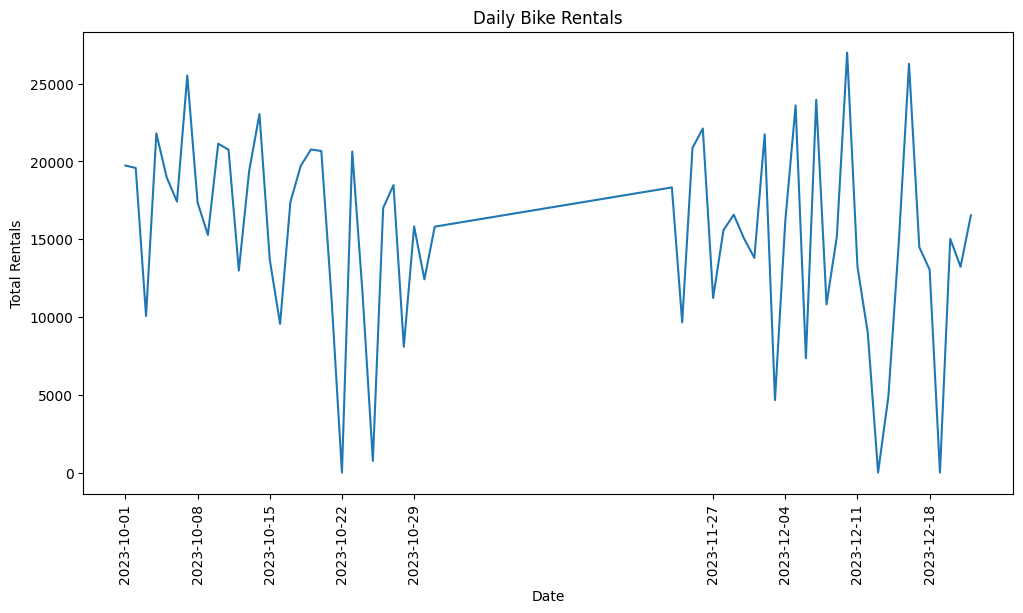

In [4]:
# analysis on a trend in a month

# Convert 'DateHour' to datetime
bikes['DateHour'] = pd.to_datetime(bikes['DateHour'])

# Group by date to aggregate rentals by day
bikes['Date'] = bikes['DateHour'].dt.date
daily_rentals = bikes.groupby('Date')['RENTALS'].sum()

# Plot the line chart for daily rentals
plt.figure( figsize = (12, 6))
plt.plot(daily_rentals.index, daily_rentals.values)
plt.title('Daily Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Total Rentals')

#OpenAI, chatgpt
# Define your step
step = 7  # Display one label every 7 days, for example

# Use the step to reduce the number of labels
plt.xticks(daily_rentals.index[::step], daily_rentals.index[::step], rotation=90)
plt.grid(False)
plt.show()

Numbrers of rentals in all available days doesn't show us any trend but it's obivous that there are spikes and dips. Hypothesis to explore: Rentals are influenced by weather conditions and holidays. There is a gap between Oct 31 - Nov 23 where no bikes have been rented based on the available data. Some dates indicate 0 rentals.

Room for improvement: Analysis of the 10/29 - 11/27 period

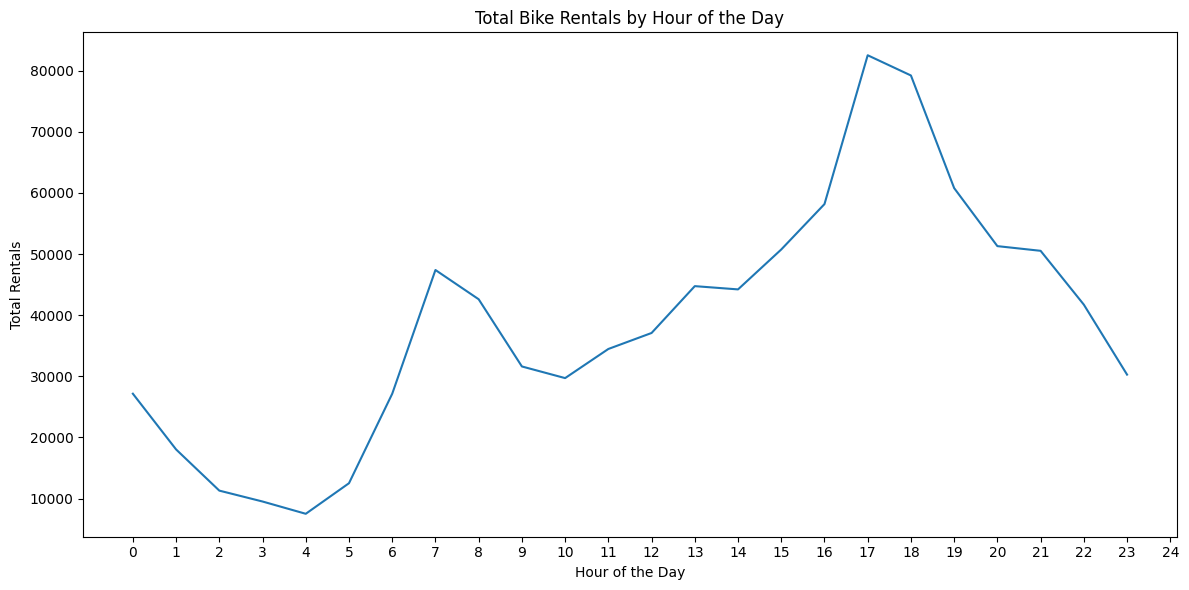

In [5]:
# analysis on a trend in a daytime

# Extract the hour from 'DateHour'
bikes['Hour'] = bikes['DateHour'].dt.hour

# Group by 'Hour' and sum the rentals
rentals_by_hour = bikes.groupby('Hour')['RENTALS'].sum()

# Plot the data
plt.figure(figsize = (12, 6))
plt.plot(rentals_by_hour.index, rentals_by_hour.values)
plt.title('Total Bike Rentals by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Rentals')
plt.xticks(range(0, 25))  # Set x-axis labels from 0 to 24
plt.grid(False)
plt.tight_layout()
plt.show()



One of the data point helping us to strategize our operations is the understanding of how the rentals are distributed in the day. This graph with Hour of the day (military time) on x axis and Total rentals in a given period on y axis shows the deistribution of the rentals within a day. Based on the available data we can clearly say that we start renting our bikes from 4am with little bit of valley from 7am to 1pm following by the steep increase of rentals till 5pm where we experience peak. From that point the rentals decrease. There is no available data for midnight but we can assume continueus decline that reaches the below 10000 rentals at 4am. It's good to notice that in the peak we rent more than 8x more than in the bottom in the given period of the data set from Oct 1, 2023 to Dec 22, 2023.


Correlation of weather conditions with bike rentals:

DateHour                 -0.12
Temperature(F)            0.31
Humidity(%)              -0.33
Wind speed (mph)          0.17
Visibility(miles)         0.04
DewPointTemperature(F)    0.06
Rainfall(in)             -0.12
Snowfall(in)             -0.12
SolarRadiation(MJ/m2)     0.20
RENTALS                   1.00
DayOfWeek                 0.08
Hour                      0.47
Name: RENTALS, dtype: float64


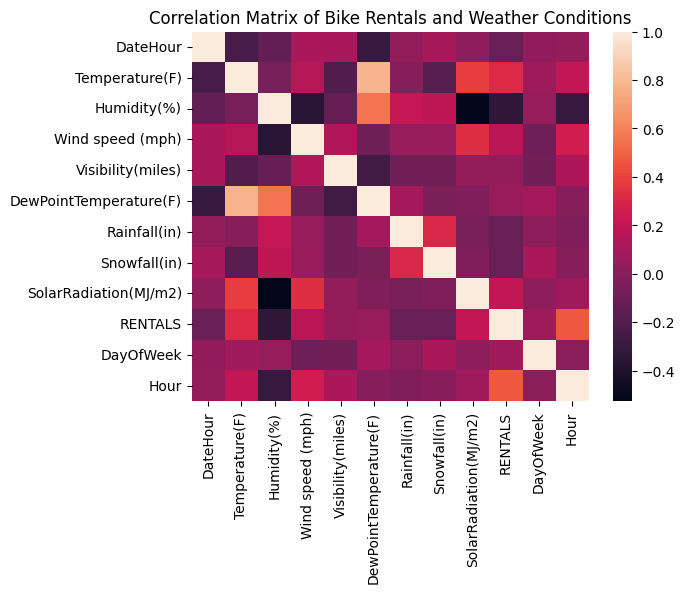

In [6]:
# correlation of the weather condition attributes with bike rentals and visualisation


#Group by date to aggregate rentals by day
bikes['Date'] = bikes['DateHour'].dt.date

# Drop the 'Date', 'Holiday', and 'FunctioningDay' columns for the correlation analysis
bikes_for_correlation = bikes.drop(columns = [ 'Date', 'Holiday', 'FunctioningDay'])

# Compute the Pearson correlation matrix
correlation_matrix = bikes_for_correlation.corr(method='pearson')

# Extract correlations with the 'RENTALS' column
correlation_with_rentals = correlation_matrix['RENTALS']
correlation_with_rentals = correlation_with_rentals.round(2)  # Round to 2 decimal places

# Print the correlation results
print(f"\nCorrelation of weather conditions with bike rentals:\n\n{correlation_with_rentals}")

# Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix of Bike Rentals and Weather Conditions')
plt.show(block = True)

This heatmap helps us understand the correlation between weather conditions and rentals. There are some attributes impacting the rentals positively and some negatively. Based on this data we can state following:

The bikes are more likely be rented in warmer weather. The higher humidity levels impacts negatively the rentals. Both rainfall and snowfall impacts the rentals negatively as well. The higher radiation which perhaps can be understand as the sunny days are slightly associated with the more bike rentals. Wind has also negative impact on the rentals.
While non of the above has a strong correlation as a single attribute the rest of the attributes have a minimal or no significant correlation with the rentals.



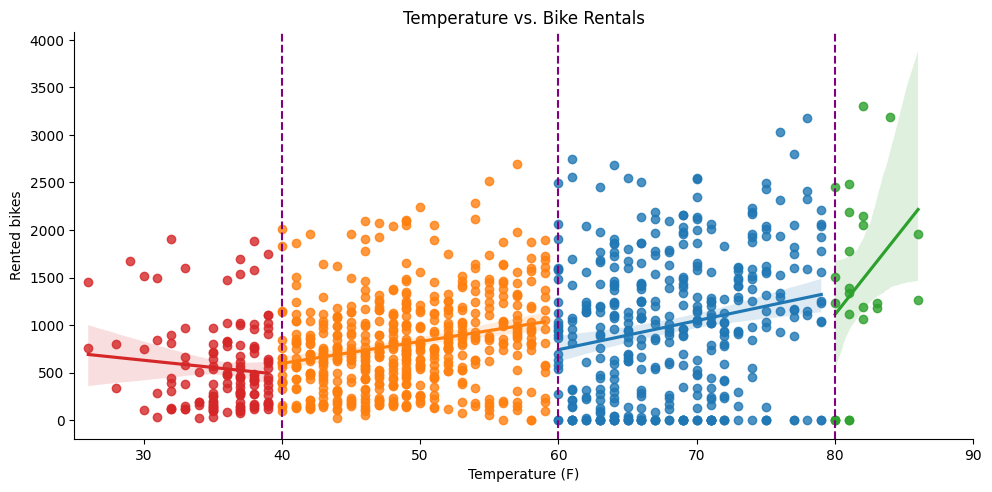

In [7]:
# creating a dummy column
bikes['Rented bikes'] = ""


# for loop with iterrows() <-- one of the most useful methods for DataFrames
for index, col in bikes.iterrows():
    
    
    # conditionals to change the values in the new column
    if bikes.loc[index, 'Temperature(F)'] < 20:
        bikes.loc[index, 'Rented bikes'] = '[0, 20)'
        
        
    elif bikes.loc[index, 'Temperature(F)'] < 40:
         bikes.loc[index, 'Rented bikes'] = '[20 - 40)'
        
        
    elif bikes.loc[index, 'Temperature(F)'] < 60:
         bikes.loc[index, 'Rented bikes'] = '[40 - 60)'
        
        
    elif bikes.loc[index, 'Temperature(F)'] < 80:
         bikes.loc[index, 'Rented bikes'] = '[60 - 80)'
        
        
    elif bikes.loc[index, 'Temperature(F)'] >= 80: 
        bikes.loc[index, 'Rented bikes'] = '[80 - inf)'
    
    
    # safety net
    else:
        bikes.loc[index, 'Rented bikes'] = 'error'


# instantiating an lmplot for carat and price
sns.lmplot(x          = 'Temperature(F)',  
           y          = 'RENTALS',  
           hue        = 'Rented bikes', # categorical data for subsets
           legend     = False       , # supressing the legend 
           scatter    = True        ,     
           fit_reg    = True        ,     
           aspect     = 2           ,        
           data       = bikes    )


# developing vertical axis lines
value = 0

while value < 100:
    
    # making a vertical line
    plt.axvline(x = value, color = "purple", linestyle = '--')
    
    # incrementing value in one-quarter increments
    value += 20


plt.title('Temperature vs. Bike Rentals')
plt.xlabel('Temperature (F)')
plt.ylabel('Rented bikes')
plt.xlim        (left   = 25, right = 90          ) # adjusting the display area 
plt.tight_layout(pad    = 1.0                     )
plt.show        (block  = True                    )

The distribution of the rentals on the graph suggest that there is a trend showing us that the higher temperature the more rentals in a range of 20-80F. Especially in the 40-60 temperature which looks the most favorable based on the density. There is no bike rented in a temperature below 20F. The closer to 90F it gets the fewer bikes rented. There are no bikes rented when temperature exeeds 85F.